
Training Confusion Matrix:
  [[25152  2266]
 [ 1866  1607]]

Testing Confusion Matrix:
  [[8324  806]
 [ 660  507]]

Training Accuracy Score:  0.8662393577417371

Testing Accuracy Score:  0.8576284354666408

Training Precision:  0.41492383165504776

Testing Precision:  0.38613861386138615

Training Recall:  0.462712352433055

Testing Recall:  0.43444730077120824

Train Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.92      0.92     27418
           1       0.41      0.46      0.44      3473

   micro avg       0.87      0.87      0.87     30891
   macro avg       0.67      0.69      0.68     30891
weighted avg       0.87      0.87      0.87     30891


Test Classification Report: 
               precision    recall  f1-score   support

           0       0.93      0.91      0.92      9130
           1       0.39      0.43      0.41      1167

   micro avg       0.86      0.86      0.86     10297
   macro avg       0.66   

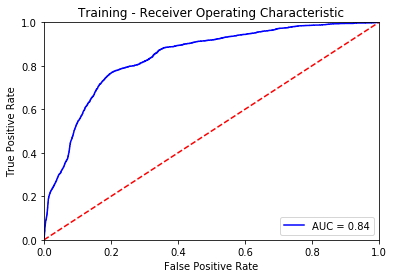

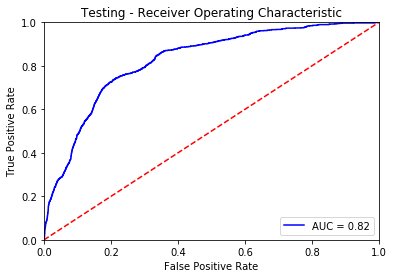

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.naive_bayes import GaussianNB, MultinomialNB
import pickle
from src.evaluate import evaluate

df_train = pd.read_csv('./data/benchmark/benchmark_normalized_train.csv')
df_test = pd.read_csv('./data/benchmark/benchmark_normalized_test.csv')

df_train_class = pd.DataFrame(df_train['y'])
df_train_features = df_train.loc[:, df_train.columns != 'y']

df_test_class = pd.DataFrame(df_test['y'])
df_test_features = df_test.loc[:, df_test.columns != 'y']

'''
Create array for continuous variables
'''
#continuous_features = ['age', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']
continuous_features = ['age', 'duration', 'campaign', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m', 'nr.employed']

'''
Create dataframes for continuous and categorical variables for gaussian and multinomial nb
'''
df_train_features_con = df_train_features.loc[:,df_train_features.columns.isin(continuous_features)]
df_train_features_cat =  df_train_features.loc[:,~df_train_features.columns.isin(continuous_features)]

df_test_features_con = df_test_features.loc[:, df_test_features.columns.isin(continuous_features)]
df_test_features_cat =  df_test_features.loc[:,~df_test_features.columns.isin(continuous_features)]

'''
Fit gaussian model on continuous features
'''
gaussian_nb = GaussianNB()
gaussian_nb.fit(df_train_features_con, df_train_class.values.ravel())

gaussian_predicted_prob_train = gaussian_nb.predict_proba(df_train_features_con)
gaussian_predicted_prob_test = gaussian_nb.predict_proba(df_test_features_con)


'''
Fit multinomial model on categorical features
'''
multinomial_nb = MultinomialNB()
multinomial_nb.fit(df_train_features_cat, df_train_class.values.ravel())

multinomial_predicted_prob_train = multinomial_nb.predict_proba(df_train_features_cat)
multinomial_predicted_prob_test = multinomial_nb.predict_proba(df_test_features_cat)

combined_predicted_prob_train = np.vstack([gaussian_predicted_prob_train[:,1],multinomial_predicted_prob_train[:,1]]).T
combined_predicted_prob_test = np.vstack([gaussian_predicted_prob_test[:,1],multinomial_predicted_prob_test[:,1]]).T

gaussian_nb_final = GaussianNB()
gaussian_nb_final.fit(combined_predicted_prob_train, df_train_class.values.ravel())

predicted_train = gaussian_nb_final.predict(combined_predicted_prob_train)
predicted_test = gaussian_nb_final.predict(combined_predicted_prob_test)

predicted_prob_train = gaussian_nb_final.predict_proba(combined_predicted_prob_train)
predicted_prob_test = gaussian_nb_final.predict_proba(combined_predicted_prob_test)


with open('./models/naive_bayes/benchmark_nb_normalized_model.sav', 'wb') as f:
    pickle.dump(gaussian_nb_final, f)

evaluate(df_train_class, predicted_train, predicted_prob_train, df_test_class, predicted_test, predicted_prob_test, 'y')